# Real time stream processing with Kafka - Part 2.1
## Thanasak Harisombut

Date: 21/10/2020

Version: 1.0

Environment: Python 3.7.4 and Jupyter notebook


## 2.1 Process Event Consumer

In [3]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from json import loads
import pandas as pd

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Streaming_Linux_process'


def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='latest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width, height)) # create new figure
        fig.subplots_adjust(hspace=20)
        ax = fig.add_subplot(111)  # adding the subplot axes to the given grid position
        ax.set_xlabel('Time')
        ax.set_ylabel('Record count')  
        fig.suptitle('Real-time record counting stream data visualization') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        
        return fig, ax
    except Exception as ex:
        print(str(ex))
    

<IPython.core.display.Javascript object>


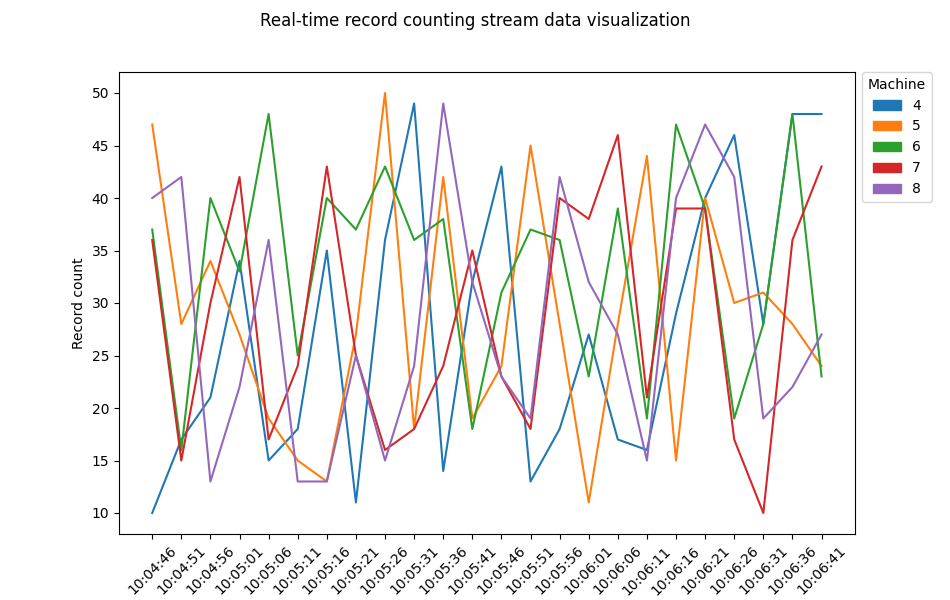

<ipython-input-4-e6490cd6708f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['ts_convert'] = selected_data.apply(lambda row: str(dt.datetime.fromtimestamp(int(row.ts)).time()), axis=1)


KeyboardInterrupt: 

In [4]:
def consume_messages(consumer, fig, ax):
    try:
        
        DELAY_TIME = 120     # 120 sec (2 min)
        data = pd.DataFrame(columns=['ts'])
        start_batch_time = dt.datetime.utcnow()
        
        for message in consumer:
            d_content = loads(str(message.value).replace("\'","\""))
            data = pd.concat([data, pd.DataFrame(d_content)]).reset_index(drop=True) # append dataframes
            
            if (dt.datetime.utcnow() - start_batch_time).seconds >= DELAY_TIME:
                end_batch_time = start_batch_time + dt.timedelta(0, DELAY_TIME)   # set end_batch_time 

#                 print("Batch between {} & {}".format(start_batch_time, end_batch_time))

    
                selected_data = data[(data.ts >= str(int(start_batch_time.timestamp()))) & (data.ts < str(int(end_batch_time.timestamp())))]
                data.drop(selected_data.index.values.tolist(), inplace=True)  # drop the selected index in data
                
                selected_data['ts_convert'] = selected_data.apply(lambda row: str(dt.datetime.fromtimestamp(int(row.ts)).time()), axis=1)
    
                selected_data = selected_data.groupby(['ts_convert','machine']).agg({'sequence': ['count']}) \
                                                                     .sort_values('ts_convert',ascending=True)
                selected_data = selected_data.reset_index()
                
                # get all machine id
                machine_id = list(selected_data.machine.unique())
                machine_id.sort()
            
            
                # plot graph
                ax.clear()
                color_list = list(matplotlib.colors.TABLEAU_COLORS)
                legend_path = []
                
                for mc in machine_id:
                    # set plot
                    x = list(selected_data[selected_data.machine == mc].ts_convert)
                    y = list(selected_data[selected_data.machine == mc].sequence['count'])
                    ax.plot(x, y, color= color_list[machine_id.index(mc)])
                    
                    # set legend
                    legend_path.append(mpatches.Patch(color=color_list[machine_id.index(mc)], label=str(int(mc))))
                    
                ax.set_xlabel('Time')
                ax.set_ylabel('Record count')
                plt.xticks(rotation=45)
                
                
                # add legend
                plt.legend(title="Machine", handles=legend_path, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
                fig.canvas.draw()
                
    
                # reset variables
                start_batch_time = end_batch_time
    
            
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()    
    consume_messages(consumer, fig, ax) 
    